### Prerequisites:

This AgenticRAG example uses GPT-4.1 via AzureChatOpenAI, which requires certain environment variables to be configured.
You can substitute any other LLM if preferred.

Create a .env file in the same directory as your project and define the following variables:
- AZURE_OPENAI_ENDPOINT
- AZURE_OPENAI_KEY
- AZURE_OPENAI_DEPLOYMENT
- AZURE_OPENAI_API_VERSION

You'll also need to set Elasticsearch environment variables as `ES_URL`, `ES_USERNAME` and `ES_PASSWORD` to set up connection with Elasticsearch vectorstore

In [23]:
import os
import time

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableSequence
from langchain_openai import AzureChatOpenAI
from langchain.chains import LLMChain, SequentialChain
from datasets import load_dataset
from langchain.schema import Document
from langchain_elasticsearch import ElasticsearchStore, SparseVectorStrategy
from dotenv import load_dotenv
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, List, Literal
from loguru import logger
from pydantic import BaseModel, Field
from elasticsearch import Elasticsearch, NotFoundError, BadRequestError
from elasticsearch.exceptions import AuthenticationException
from IPython.display import Image

load_dotenv()

True

In [4]:
#!pip3 install langchain langgraph langchain-openai langchain-elasticsearch langchain-community datasets python-dotenv loguru elasticsearch "pydantic>=2.0"

### Install ELSER

In [26]:
def get_elastic_credentials():
    try:
            es_url = os.environ["ES_URL"]
    except KeyError:
            raise Exception(
                "Environment variable ES_URL (Elasticsearch URL) is not set. Please set it."
            )
    try:
            es_username = os.environ["ES_USERNAME"]
    except KeyError:
            raise Exception(
                "Environment variable ES_USERNAME (Elasticsearch username) is not set. Please set it."
            )
    try:
            es_password = os.environ["ES_PASSWORD"]
    except KeyError:
            raise Exception(
                "Environment variable ES_PASSWORD (Elasticsearch password) is not set. Please set it."
            )
    return es_url, es_username, es_password

def get_elastic_client(es_url: str, username: str, password: str):
        try:
            es_args = {
                "hosts": [es_url],
                "basic_auth": (username, password),
                "request_timeout": 100,
                "max_retries": 3,
                "retry_on_timeout": True,
            }

            client = Elasticsearch(**es_args)
            return client
        except AuthenticationException as ae:
            raise Exception(
                f"Elasticsearch connection failed due to authentication error: {ae}. Please check your Elasticsearch URL and credentials"
            )
        except Exception as e:
            raise Exception(f"Elasticsearch connection failed: {e}.")

In [27]:
url, username, password = get_elastic_credentials()
es=get_elastic_client(url, username, password)

In [15]:
def install_elser(es: Elasticsearch, model_id: str):
    try:
        es.ml.get_trained_models(model_id=model_id)
    except NotFoundError:
        logger.info(f'"{model_id}" not found. Installing...')
        es.ml.put_trained_model(model_id=model_id, input={"field_names": ["text_field"]})

    while True:
        status = es.ml.get_trained_models(model_id=model_id, include="definition_status")
        if status["trained_model_configs"][0]["fully_defined"]:
            break
        time.sleep(1)

    stats = es.ml.get_trained_models_stats(model_id=model_id)
    allocation_state = stats["trained_model_stats"][0].get("deployment_stats", {}).get("allocation_status", {}).get("state")
    if allocation_state != "fully_allocated":
        try:
            es.ml.start_trained_model_deployment(model_id=model_id, wait_for="fully_allocated")
        except BadRequestError:
            pass

    logger.info(f'"{model_id}" model is ready')

In [8]:
install_elser(es, ".elser_model_2")

2025-10-28 09:41:24.521 | INFO     | __main__:install_elser:22 - ".elser_model_2" model is ready


### Define your LLM

In [16]:
llm = AzureChatOpenAI(
    azure_deployment=os.environ.get('AZURE_OPENAI_DEPLOYMENT'),
    azure_endpoint=os.environ.get('AZURE_OPENAI_ENDPOINT'),
    api_version=os.environ.get('AZURE_OPENAI_API_VERSION'),
    api_key=os.environ.get('AZURE_OPENAI_KEY')
)

#### Load AG news dataset

In [17]:
dataset = load_dataset("ag_news", split="train[:1000]")
docs = [
        Document(
            page_content=sample["text"],
            metadata={"category": sample["label"]}
        )
        for sample in dataset
    ]


#### Add documents to Elasticsearch vector store

In [28]:
index_name="news_docs"
elastic_vectorstore = ElasticsearchStore.from_documents(
    docs,
    es_url=os.environ["ES_URL"],
    es_user=os.environ["ES_USERNAME"],
    es_password=os.environ["ES_PASSWORD"],
    index_name=index_name,
    strategy=SparseVectorStrategy(model_id=".elser_model_2"),
)

elastic_vectorstore.client.indices.refresh(index=index_name)

ObjectApiResponse({'_shards': {'total': 2, 'successful': 2, 'failed': 0}})

### Define your data retrieval options

In [19]:
def vectorstore_retriever(query, k=5):
    results = elastic_vectorstore.similarity_search_with_score(query, k=k)
    docs = [doc for doc, score in results]
    related_docs = "\n".join([d.page_content for d in docs])
    return related_docs

duckduckgo = DuckDuckGoSearchRun(description= "A custom DuckDuckGo search tool for finding latest news stories.", verbose=True)
def websearch_retriever(query):
    results = duckduckgo.run(f"{query}")
    return results

def hybrid_retriever(query):
    related_docs = vectorstore_retriever(query)
    related_docs += websearch_retriever(query)
    return related_docs

### Define your LLM Chains

In [20]:
class RouteQuery(BaseModel):
    datasource: Literal["vectorstore", "websearch", "hybrid"] = Field(
        ...,
        description="Choose to route the query to web search, vectorstore or hybrid."
    )

router_prompt = ChatPromptTemplate.from_template("""You are an assistant that decides the best data source for news articles based questions.

Choose one of the following options:
- 'vectorstore': for general, background, or historical news articles.
- 'websearch': for recent discoveries, 'latest', 'current', or '2025' type queries.
- 'hybrid': when the question needs both historical and current knowledge on news articles.

Question: {query}

Return one word: 'vectorstore', 'websearch', or 'hybrid'.
""")
router_structured = llm.with_structured_output(RouteQuery)
router_chain: RunnableSequence = router_prompt | router_structured

class GradeRetrievedDocs(BaseModel):
    binary_score: bool = Field(
        description="True if retrieved documents match the query intent, False otherwise."
    )

grade_retrieved_docs_prompt = ChatPromptTemplate.from_template("""
You are an evaluator that determines whether the retrieved documents are relevant to the given user query.

Instructions:
- Compare the intent and information need of the query against the retrieved documents.
- Answer only 'True' or 'False'.
- 'True' means the retrieved documents align with the query’s intent and can likely answer it.
- 'False' means the retrieved documents do not address the main topic or intent of the query.

Return only one word: 'True' or 'False'.

Query:
{query}

Retrieved Documents:
{docs}
""")

retrieved_docs_structured = llm.with_structured_output(GradeRetrievedDocs)
grade_docs_chain: RunnableSequence = grade_retrieved_docs_prompt | retrieved_docs_structured

class RewrittenQuery(BaseModel):
    query: str

rewrite_query_prompt = ChatPromptTemplate.from_template("""
The grader returned that the retrieved documents do not answer the query. Reformulate the query to better capture the user's intent and retrieve relevant information. Return ONLY the rewritten query, concise and clear. Just the string i.e. the rewritten query.

Original Query:
{query}
""")
rewritten_query_structured = llm.with_structured_output(RewrittenQuery)
rewrite_query_chain: RunnableSequence = rewrite_query_prompt | rewritten_query_structured

summarize_prompt = ChatPromptTemplate.from_template( """You are a helpful news assistant. Your task is to summarize the retrieved news articles in a concise and accurate way that directly answers the user's query.
User Query:
{query}

Retrieved Articles:
{docs}

Instructions:
- Focus on the most relevant information that answers the query.
- Do not include unrelated details.
- Present the summary in clear, coherent sentences.
- If multiple articles provide overlapping information, combine them without repetition.

Summary:"""
)
summarize_chain = LLMChain(llm=llm, prompt=summarize_prompt, output_parser=StrOutputParser())


/var/folders/mb/g20y910n51gdd16_2c0vflr00000gn/T/ipykernel_19273/691602315.py:74: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  summarize_chain = LLMChain(llm=llm, prompt=summarize_prompt, output_parser=StrOutputParser())


### Start building the StateGraph

In [21]:
class RAGState(TypedDict):
    query: str
    docs: List[Document]
    router: str
    summary: str
    self_reflection: bool
    retry_count: int = 0

def router(state: RAGState):
    router = router_chain.invoke({'query': state["query"]})
    logger.info(f"Router selected the datasource: {router.datasource}")
    logger.info(f"User query: {state['query']}")
    return {"router": router.datasource}

def vectorstore(state: RAGState):
    return {"docs": vectorstore_retriever(state["query"])}

def websearch(state: RAGState):
    return {"docs": websearch_retriever(state["query"])}

def hybrid(state: RAGState):
    return {"docs": hybrid_retriever(state["query"])}

def self_reflection(state: RAGState):
    evaluation = grade_docs_chain.invoke(
        {"query": state["query"], "docs": state["docs"]}
    )
    if evaluation.binary_score:
        logger.info(f"Self-reflection passed — binary_score={evaluation.binary_score}")
    else:
        logger.info(f"Self-reflection failed — binary_score={evaluation.binary_score}")

    return {
        "self_reflection": evaluation.binary_score,
    }

def query_rewriter(state: RAGState):
    retry_count = state.get("retry_count", 0) + 1
    new_query = rewrite_query_chain.invoke({"query": state["query"]})
    logger.info(f"Query rewritten: {new_query}, retry_count: {retry_count}")
    return {
        "query": new_query,
        "retry_count": retry_count,
    }

def summarize(state: RAGState):
    summary = summarize_chain.run(
        query=state["query"],
        docs=state["docs"],
    )
    return {"summary": summary}

### Build Graph with LangChain

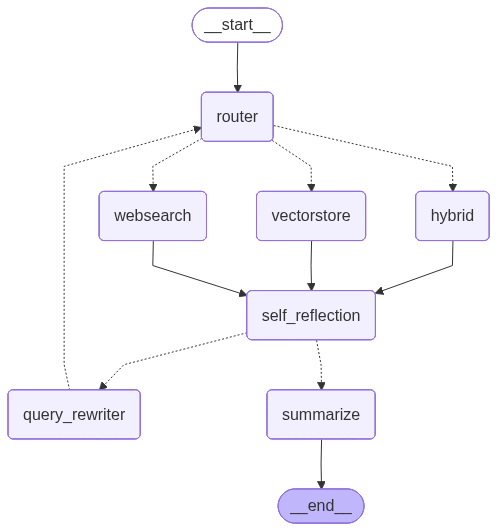

In [22]:
graph = StateGraph(RAGState)

graph.add_node("router", router)
graph.add_node("vectorstore", vectorstore)
graph.add_node("websearch", websearch)
graph.add_node("hybrid", hybrid)
graph.add_node("self_reflection", self_reflection)
graph.add_node("query_rewriter", query_rewriter)
graph.add_node("summarize", summarize)

graph.add_edge(START, "router")

def after_router(state: RAGState):
    route = state.get("router", None)
    if route == "vectorstore":
        return "vectorstore"
    elif route == "websearch":
        return "websearch"
    else:
        return "hybrid"

def after_self_reflection(state: RAGState):
    if state["self_reflection"]:
            return "summarize"
    return "query_rewriter"

def after_query_rewriter(state: RAGState):
    while state['retry_count'] <= 3:
            return "router"
    raise RuntimeError("Maximum retries (3) reached — evaluation failed.")

graph.add_conditional_edges(
    "router",
    after_router,
    {
        "vectorstore": "vectorstore",
        "websearch": "websearch",
        "hybrid": "hybrid"
    }
)

graph.add_edge("vectorstore", "self_reflection")
graph.add_edge("websearch", "self_reflection")
graph.add_edge("hybrid", "self_reflection")
graph.add_conditional_edges(
    "self_reflection",
    after_self_reflection,
    {
        "summarize": "summarize",
        "query_rewriter": "query_rewriter"
    }
)
graph.add_conditional_edges("query_rewriter", after_query_rewriter, {"router": "router"})
graph.add_edge("summarize", END)
agent=graph.compile()
agent.get_graph().draw_mermaid_png(output_file_path='graph.png')
Image('graph.png')

### Start testing

In [24]:
query1="What are the latest AI models released this month?"
query2="What technological innovations are discussed in Sci/Tech news?"
query3="Compare a Sci/Tech article from the dataset with a current web article about AI trends."

In [26]:
result = agent.invoke({"query": query1})
logger.info(f"\nFinal Summary:\n: {result['summary']}")

2025-10-27 12:21:40.530 | INFO     | __main__:router:11 - Router selected the datasource: websearch
2025-10-27 12:21:40.532 | INFO     | __main__:router:12 - User query: What are the latest AI models released this month?


March 31, 2025 - It also gives users control over how long the model can think for, per Anthropic. Sonnet 3.7 is available to all Claude users, but heavier users will need a $20-per-month Pro plan. Grok 3 is the latest flagship model from Elon Musk-founded startup ... October 30, 2024 - What's particularly noteworthy is that the Llama 3.1 -Nemotron-70B-Instruct model has shown outstanding results in automatic benchmarks, outperforming even some of the most advanced models in the field, including Claude 3.5 Sonnet and GPT-4. ... March 26, 2025 - Grok 3: DeepSearch can significantly enhance developers’ ability to conduct research, find relevant resources, and stay informed about the latest advancements in their field. The upcoming release of the Grok 3 API will further empower developers ... September 10, 2025 - We had an AI Mode in Search expansion, ... round out the month — including a new image editing release in the Gemini app (Nano Banana) and Google DeepMind’s first real-time inter

2025-10-27 12:21:41.999 | INFO     | __main__:self_reflection:31 - Self-reflection failed — binary_score=False
2025-10-27 12:21:42.626 | INFO     | __main__:query_rewriter:40 - Query rewritten: query='Which AI models have been launched or published in June 2024?', retry_count: 1
2025-10-27 12:21:43.194 | INFO     | __main__:router:11 - Router selected the datasource: websearch
2025-10-27 12:21:43.195 | INFO     | __main__:router:12 - User query: query='Which AI models have been launched or published in June 2024?'


Jul 2, 2024 · Discover the top AI news of June 2024 , including Apple Intelligence Figma's AI feature controversy, Runway's Gen-3 Alpha launch , and more. Jun 26, 2024 · Today, we delve into the latest rankings of AI models , highlighting the most powerful generative language models as of June 2024 . Jun 4, 2025 · We saw the release of a range of platform models , from Claude 4 by Anthropic, to Google’s Veo 3, a model that generates synchronized audio and video content. In the open source ecosystem, Mistral released the Devstral model, and Alibaba released the Qwen3 series of models . Feb 28, 2025 · With new AI models launched in the market in 2025 and 2024 , it can be overwhelming to keep track of them all. We have compiled a listed guide to the newest and most advanced AI models , what they do, and how to use them. Our public database, the largest of its kind, tracks over 3100 machine learning models from 1950 to today. Explore data and graphs showing the trajectory of AI .

2025-10-27 12:21:45.407 | INFO     | __main__:self_reflection:29 - Self-reflection passed — binary_score=True
2025-10-27 12:21:46.972 | INFO     | __main__:<module>:2 - 
Final Summary:
: In June 2024, several notable AI models were launched or published, including Runway's Gen-3 Alpha, Anthropic's Claude 4, Google's Veo 3 (which generates synchronized audio and video), Mistral's open-source Devstral model, and Alibaba's Qwen3 series.


In [27]:
result = agent.invoke({"query": query2})
logger.info(f"\nFinal Summary:\n: {result['summary']}")

2025-10-27 12:22:25.073 | INFO     | __main__:router:11 - Router selected the datasource: vectorstore
2025-10-27 12:22:25.075 | INFO     | __main__:router:12 - User query: What technological innovations are discussed in Sci/Tech news?
/Users/kirtisodhi/agentic-rag/path/to/venv/lib/python3.13/site-packages/langchain_elasticsearch/_sync/vectorstores.py:530: ElasticsearchWarning: text_expansion is deprecated. Use sparse_vector instead.
  hits = self._store.search(
2025-10-27 12:22:25.998 | INFO     | __main__:self_reflection:29 - Self-reflection passed — binary_score=True
2025-10-27 12:22:27.416 | INFO     | __main__:<module>:2 - 
Final Summary:
: Recent Sci/Tech news highlights several technological innovations: NASA is collaborating with Silicon Valley firms to build a powerful Linux-based supercomputer for theoretical research and shuttle engineering; Genetic Savings & Clone has developed chromatin transfer technology to clone cats; Princeton scientists report that existing technologie

In [28]:
result = agent.invoke({"query": query3})
logger.info(f"\nFinal Summary:\n: {result['summary']}")

2025-10-27 12:22:37.566 | INFO     | __main__:router:11 - Router selected the datasource: hybrid
2025-10-27 12:22:37.568 | INFO     | __main__:router:12 - User query: Compare a Sci/Tech article from the dataset with a current web article about AI trends.
/Users/kirtisodhi/agentic-rag/path/to/venv/lib/python3.13/site-packages/langchain_elasticsearch/_sync/vectorstores.py:530: ElasticsearchWarning: text_expansion is deprecated. Use sparse_vector instead.
  hits = self._store.search(


19 hours ago - In the late 2010s, graphics processing ... large-scale (commercial and academic) machine learning models' training. Specialized programming languages such as Prolog were used in early AI research, but general-purpose programming languages like Python have become predominant. The transistor density in integrated circuits has been observed to roughly double every 18 months—a trend known as Moore's ... Mar 4, 2025 · This article aims to equip readers with a deep understanding of AI ’ s current state and future trajectory, providing actionable insights and practical advice to navigate this transformative era. 3 weeks ago - North America, which includes the U.S. and Canada, is the market leader . In 2023, it captured 38.9% of the global AI market, which was about $97.25 billion in revenue. ... China has a much higher active adoption rate. March 12, 2025 - This article is a collaborative effort by Alex Singla, Alexander Sukharevsky, Lareina Yee, and Michael Chui, with Bryce Ha

2025-10-27 12:22:39.279 | INFO     | __main__:self_reflection:29 - Self-reflection passed — binary_score=True
2025-10-27 12:22:41.650 | INFO     | __main__:<module>:2 - 
Final Summary:
: A Sci/Tech article from the dataset highlights how NASA is developing advanced artificial intelligence (AI) software for planetary rovers, enabling them to become more autonomous and make critical decisions during missions. In comparison, a current web article about AI trends discusses the rapid evolution of AI technologies, such as large-scale models with advanced reasoning capabilities (like OpenAI o1), the widespread adoption of AI in various sectors, and the importance of responsible AI governance in organizations to maximize business impact. Both articles emphasize the increasing sophistication and self-reliance of AI systems, but while the NASA article focuses on specialized applications for space exploration, the current web article covers broader AI trends, advancements in reasoning, market gro